# PR1: Medical Text Classification

* Author: Kevin Chuang [@k-chuang](https://www.github.com/k-chuang)
* Created on: September 21, 2018
* Description: Given a medical abstract, classify condition of patient (5 classes) using K-Nearest Neighbors.

-----------

## Import libraries

In [1]:
__author__ = 'Kevin Chuang (https://www.github.com/k-chuang)' 

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# Text Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Natural Language Processing
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

# Metrics
from sklearn.metrics import f1_score

# Utilities
import string
import math
from operator import itemgetter 
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
import scipy.sparse as sp

%matplotlib inline


sns.set(rc={"figure.figsize": (20.0, 10.0), "axes.labelsize": 14})

# sns.set_context("poster")

## Load data

In [2]:
train_df = pd.read_csv('data/train.dat', sep='\t', header=None, names=['Label', 'Abstract'])
test_df = pd.read_csv('data/test.dat', sep='\t', header=None, names=['Abstract'])
submission_df = pd.read_csv('data/format.dat', header=None, names=['Labels'])

In [3]:
train_df.head()

,Label,Abstract
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...


In [4]:
test_df.head()

,Abstract
0,Excision of limbal dermoids. We reviewed the c...
1,Bell's palsy. A diagnosis of exclusion. In cas...
2,Retained endobronchial foreign body removal fa...
3,Recurrent buccal space abscesses: a complicati...
4,Intracranial fibromatosis. Fibromatoses are un...


## Data Exploration

- View a sample of the medical abstract text
- Read through it, and I definitely had to Google some terminology
    - Initial observations of medical abstract text
        - There are a lot of complex medical terms (e.g. acute myocardial infarction) 
        - There seems to be a lot of n = some integer (e.g. n = 100)
        - There seems to be a lot of percentages (e.g. 55%)
- Imbalanced Classes
    - Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration.
    - Need configure model or artifically balance the dataset (oversampling under-represented classes and undersampling over-represented classes)
- Classes?
    - 1: Neoplasms
    - 2: Digestive System Diseases
    - 3: Nervous System Diseases
    - 4: Cardiovascular Diseases
    - 5: General Pathological conditions

In [5]:
# Check for null abstracts
train_df.Abstract.isnull().sum()

0

In [6]:
# Check for null labels
train_df.Label.isnull().sum()

0

In [7]:
train_df['Abstract'][0]

'Catheterization laboratory events and hospital outcome with direct angioplasty for acute myocardial infarction To assess the safety of direct infarct angioplasty without antecedent thrombolytic therapy, catheterization laboratory and hospital events were assessed in consecutively treated patients with infarctions involving the left anterior descending (n = 100 patients), right (n = 100), and circumflex (n = 50) coronary arteries. The groups of patients were similar for age (left anterior descending coronary artery, 59 years; right coronary artery, 58 years; circumflex coronary artery, 62 years), patients with multivessel disease (left anterior descending coronary artery, 55%; right coronary artery, 55%; circumflex coronary artery, 64%), and patients with initial grade 0/1 antegrade flow (left anterior descending coronary artery, 79%; right coronary artery, 84%; circumflex coronary artery, 90%). Cardiogenic shock was present in eight patients with infarction of the left anterior descen

In [8]:
train_df['Abstract'][1]

'Renal abscess in children. Three cases of renal abscesses in children are described to illustrate the variable presenting features. An additional 23 pediatric cases, reported over the past ten years, were reviewed for clinical features and therapy. Fever, loin pain, and leukocytosis were common presenting features, but less than half of all abscesses were associated with either an abnormal urinalysis or a positive urine culture. The presenting features were sometimes confused with appendicitis, peritonitis, or a Wilms tumor. An organism was identified in 17 cases--Escherichia coli in 9 children and Staphylococcus aureus in 8 children. The majority of E. coli infections occurred in girls and the majority of S. aureus infections occurred in boys. Reflux was documented in 5 patients, and 2 children had a possible extrarenal source of infection. Antibiotics alone produced a cure in 10 children (38%), but 16 children (62%) required a surgical procedure. '

In [9]:
# Imbalanced classes

train_df['Label'].value_counts()

5    4805
1    3163
4    3051
3    1925
2    1494
Name: Label, dtype: int64

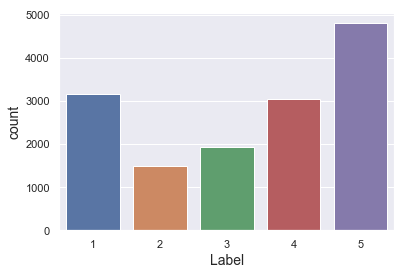

In [10]:
# Visualize the imbalanced classes
sns.countplot(x='Label', data=train_df);

## Data Preprocessing

- Going to use `Bag of Words` approach
    - presence of words (frequency or count) is taken into consideration & order is ignored
    - BOW basically breaks up the note into the individual words and counts how many times each word occurs.
- Tokenizer and a vectorizer. 
    - The tokenizer breaks a single abstract into a list of words and a vectorizer takes a list of words and counts the words.
- `Tokenizer`:
    - Remove punctuation & numbers
    - Lowercase everything
    - Two approaches for tokenization
        - Goal is reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.
        - Lemmatize all the text (e.g. women will become woman)
            - Lemmatization is the process of converting the words of a sentence to its dictionary form. 
        - Stem all the text
            - Stemming is the process of converting words to the stem (root) of the word
- `Vectorizer`:
    - General process of turning a collection of text documents into numerical feature vectors. 
    - This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. 
    - Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.
    - `CountVectorizer`
        - Encodes a vector with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.
        - `vocabulary_` is a dict/mapping of the terms to their indices in the document-term matrix, not the counts.
    - `TfidfVectorizer`
        - Convert a collection of raw documents to a matrix of TF-IDF features.
            - Normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.
        - TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.
            - *This can be extremely useful for this problem, since we have 5 categories we are trying to classify and thus certain categories (medical conditions) may have words in the medical abstract that are unique to the condition*
        - The resulting tf-idf vectors are then normalized by the Euclidean norm (L2)
        - **Since the medical text data have a lot of multi-word expressions (e.g. *left anterior descending coronary artery*), I will use N-grams (where N >= 1) to keep the local positioning of these important words **
            - Experimented with N-grams, and it seems 1-gram, 2-gram, 3-gram, and 4-grams produce best results

In [11]:
def tokenizer(text):
    '''Tokenize text into a list of preprocessed words '''
    
    # Create a string with all punctuations & digits concatenated
    num_and_punc = string.punctuation + string.digits
    
    # Create a mapping to space using string above for each num/punc & return a translation table with mapping
    t_table = str.maketrans(dict.fromkeys(num_and_punc, " "))
    
    # Lower text and use translation table to remove all punctuation and digits
    text = text.lower().translate(t_table)
    
    # Use Lemma tokenizer to tokenize the words
    lemma = WordNetLemmatizer()
    lemmas = [lemma.lemmatize(word.strip()) for word in text.split()]
    
    return lemmas

def word_tokenizer(text):
    '''Tokenize text into a list of preprocessed words '''
    
    # Create a string with all punctuations & digits concatenated
    num_and_punc = string.punctuation + string.digits
    
    # Create a mapping to space using string above for each num/punc & return a translation table with mapping
    t_table = str.maketrans(dict.fromkeys(num_and_punc, " "))
    
    # Lower text and use translation table to remove all punctuation and digits
    text = text.lower().translate(t_table)
    
    tokens = word_tokenize(text)
    return tokens

def stem_tokenizer(text):
    '''Tokenize text into a list of preprocessed words '''
    
    # Create a string with all punctuations & digits concatenated
    num_and_punc = string.punctuation + string.digits
    
    # Create a mapping to space using string above for each num/punc & return a translation table with mapping
    t_table = str.maketrans(dict.fromkeys(num_and_punc, " "))
    
    # Lower text and use translation table to remove all punctuation and digits
    text = text.lower().translate(t_table)
    # Best Stemmer for this dataset (Tested)
    stemmer = PorterStemmer()
#     stemmer = SnowballStemmer("english")
#     stemmer = LancasterStemmer()
    stems = [stemmer.stem(word.strip()) for word in text.split()]
    return stems

In [12]:
print(tokenizer(train_df['Abstract'][1]))

['renal', 'abscess', 'in', 'children', 'three', 'case', 'of', 'renal', 'abscess', 'in', 'children', 'are', 'describ', 'to', 'illustr', 'the', 'variabl', 'present', 'featur', 'an', 'addit', 'pediatr', 'case', 'report', 'over', 'the', 'past', 'ten', 'year', 'were', 'review', 'for', 'clinic', 'featur', 'and', 'therapi', 'fever', 'loin', 'pain', 'and', 'leukocytosi', 'were', 'common', 'present', 'featur', 'but', 'less', 'than', 'half', 'of', 'all', 'abscess', 'were', 'associ', 'with', 'either', 'an', 'abnorm', 'urinalysi', 'or', 'a', 'posit', 'urin', 'cultur', 'the', 'present', 'featur', 'were', 'sometim', 'confus', 'with', 'append', 'periton', 'or', 'a', 'wilm', 'tumor', 'an', 'organ', 'wa', 'identifi', 'in', 'case', 'escherichia', 'coli', 'in', 'children', 'and', 'staphylococcu', 'aureu', 'in', 'children', 'the', 'major', 'of', 'e', 'coli', 'infect', 'occur', 'in', 'girl', 'and', 'the', 'major', 'of', 's', 'aureu', 'infect', 'occur', 'in', 'boy', 'reflux', 'wa', 'document', 'in', 'patien

In [13]:
vec = CountVectorizer(tokenizer = tokenizer)
vec.fit(train_df['Abstract'])
X_train = vec.transform(train_df['Abstract'])
# abstract_df = vec.fit_transform(train_df['Abstract'])

In [14]:
# print(vec.vocabulary_)

In [15]:
# Size is around 31869 unique words

len(vec.vocabulary_)

24584

In [16]:
vocab_names = vec.get_feature_names()

In [17]:
word_counts = np.asarray(X_train.sum(axis=0))

In [18]:
vocab_counts_df = pd.DataFrame.from_dict({'Word':vocab_names, 'Counts':word_counts.ravel()})


In [19]:
vocab_counts_df.head()

,Word,Counts
0,a,44086
1,aa,28
2,aaa,27
3,aab,7
4,aaem,3


In [20]:
vocab_counts_df.sort_values(['Counts'], ascending=False).head(60)

,Word,Counts
22066,the,122496
15465,of,121285
843,and,81967
10379,in,79415
0,a,44086
24343,with,43935
22352,to,43089
16369,patient,39336
24116,wa,28458
24246,were,24358


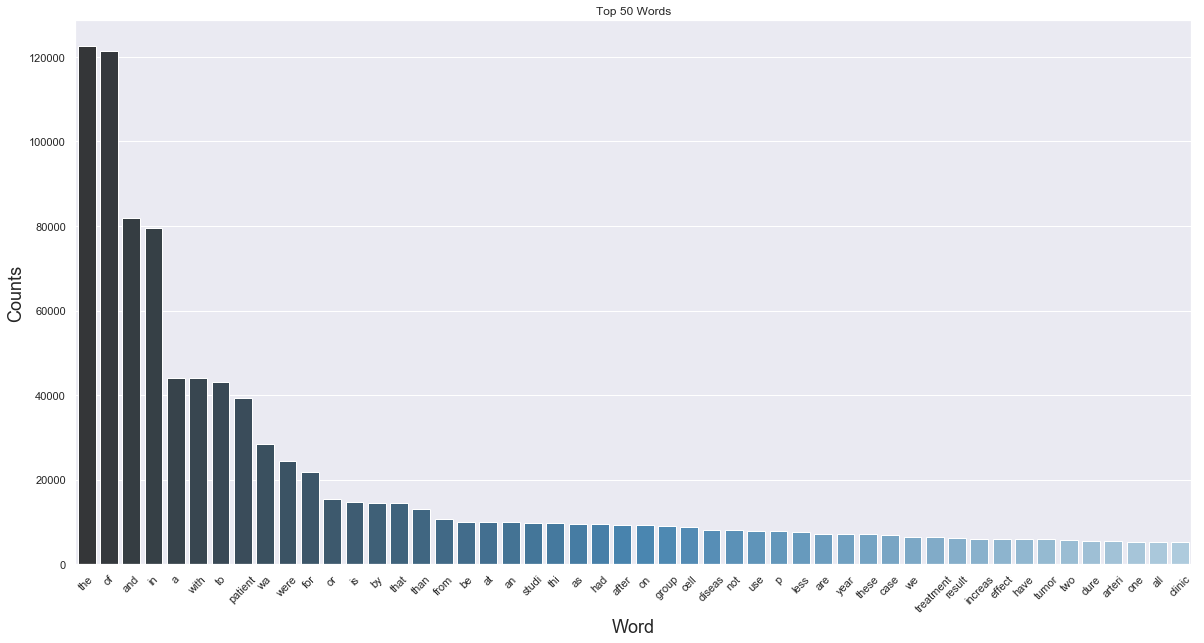

In [21]:
# Let's plot the top 50 most frequently occurring words

# Set the graph parameters
sns.set(rc={"figure.figsize": (20.0, 10.0), "axes.labelsize": 18})

top50 = vocab_counts_df.sort_values(['Counts'], ascending=False).iloc[:50]

ax = sns.barplot("Word", "Counts", data=top50, palette="Blues_d");
ax.set_title('Top 50 Words')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);


### Stop words

- Stop words are words we do not want to use as features, and shall remove from our training
- These include words like `the` or `and` or `a` that are not very important
    - We will also use the English stop words form the standard sklearn package
- Fit new `CountVectorizer` with these stop words removed

In [22]:
# Let's create our own stop words list & remove unimportant words such as 'the' or 'and'
# Also, let's use the sklearn ENGLISH_STOP_WORDS, and unionize these to create the last stop words list

my_stop_words = ['the', 'of', 'and', 'in', 'a', 'with', 'to', 
              'were', 'wa', 'for', 'or', 'is', 'by', 'that', 
              'than', 'from', 'at', 'an', 'this', 'be', 'had'
             'after', 'on', 'p', 'are', 'these', 'we', 'have', 'may', 
              'it', 'who', 'pm', 'am', 'patient', 's', 'aa', 'll', 're', 'date',
              'as', 'o', 'wa', 'year']

extra_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                    'is','patient','s','he','at','as','or','one','she','his','her','am',
                   'were','you','pt','pm','by','be','had','your','this','date', 
                   'from','there','an','that','p','are','have','has','h','but','o',
                   'namepattern','which','every','also']

# 153 stop words from NLTK
nltk_stop_words = stopwords.words('english')
# Combine stop words from all the stop word lists
stop_words = ENGLISH_STOP_WORDS.union(my_stop_words).union(extra_stop_words).union(nltk_stop_words)
# stop_words = ENGLISH_STOP_WORDS.union(nltk_stop_words)

In [23]:
# 328 stop words
len(stop_words)

389

In [24]:
count_vec = CountVectorizer(tokenizer = tokenizer, 
                       stop_words = stop_words)
count_vec.fit(train_df['Abstract'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=frozenset({'from', 'hers', 'front', 'needn', 'well', 'bill', 'mostly', 'yours', 'whole', 'above', 'cant', 'aa', 'over', "doesn't", 'mill', 'much', 'always', 'nor', 'yourselves', 'same', 'ever', 'no', 'yourself', "couldn't", 'nine', 'had', 'hence', 'throughout', 'enough', "didn't", 'what',...l', "you'll", 'me', 'did', 'at', 'may', 'them', 'theirs', 'becoming', 'patient', 'should', "don't"}),
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer at 0x11931bbf8>, vocabulary=None)

In [25]:
X_train_count = count_vec.transform(train_df['Abstract'].values)
X_test_count = count_vec.transform(train_df['Abstract'].values)

In [26]:
# Using idf
# tfidf_vec = TfidfVectorizer(tokenizer = tokenizer, norm='l2', ngram_range=(1,3), max_df = 0.4,
#                        stop_words = stop_words, use_idf=True)
tfidf_vec = TfidfVectorizer(tokenizer = tokenizer, norm='l2', ngram_range=(1,4), sublinear_tf = True,
                            stop_words = stop_words)
tfidf_vec.fit(train_df['Abstract'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'from', 'hers', 'front', 'needn', 'well', 'bill', 'mostly', 'yours', 'whole', 'above', 'cant', 'aa', 'over', "doesn't", 'mill', 'much', 'always', 'nor', 'yourselves', 'same', 'ever', 'no', 'yourself', "couldn't", 'nine', 'had', 'hence', 'throughout', 'enough', "didn't", 'what',...l', "you'll", 'me', 'did', 'at', 'may', 'them', 'theirs', 'becoming', 'patient', 'should', "don't"}),
        strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer at 0x11931bbf8>, use_idf=True,
        vocabulary=None)

In [27]:
X_train_tfidf = tfidf_vec.transform(train_df['Abstract'].values)
X_test_tfidf = tfidf_vec.transform(train_df['Abstract'].values)

In [28]:
print(X_train_tfidf[0].toarray().max())
print(X_train_tfidf[0].toarray().min())
print(X_train_tfidf[0].toarray().mean())

0.1170755053673701
0.0
6.339074283646515e-06


In [29]:
print('There are %i features' % X_train_tfidf.shape[1])

There are 2696733 features


In [30]:
Y_train = train_df['Label'].values

In [31]:
Y_train[0]

4

## Feature Selection

- Use Chi Squared Test to select top k features
    - Selects n_features with highest values for the test chi-squared statistic
    - Chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.
    - X^2 gives a measure of the distance between observed and expected frequencies.
- Visualize the top N terms that are most correlated with each medical condition/disease using Chi squared test

In [ ]:
sorted(train_df['Label'].unique())

In [ ]:
chi2(X_train_tfidf, train_df['Label'] == 1)[0][2644944]

In [34]:
N = 3
for i in sorted(train_df['Label'].unique()):
    features_chi2 = chi2(X_train_tfidf, train_df['Label'] == i)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    fourgrams = [v for v in feature_names if len(v.split(' ')) == 4]
    print("Class #%d:" % i)
    # Get last N values (np.argsort will return ascending values)
    print("  Most correlated unigrams:\n     *{}".format('\n     *'.join(unigrams[-N:])))
    print("  Most correlated bigrams:\n     *{}".format('\n     *'.join(bigrams[-N:])))
    print("  Most correlated trigrams:\n     *{}".format('\n     *'.join(trigrams[-N:])))
    print("  Most correlated four-grams:\n     *{}".format('\n     *'.join(fourgrams[-N:])))

Class #1:
  Most correlated unigrams:
     *carcinoma
     *cancer
     *tumor
  Most correlated bigrams:
     *squamou cell
     *breast cancer
     *cell carcinoma
  Most correlated trigrams:
     *basal cell carcinoma
     *diseas free surviv
     *squamou cell carcinoma
  Most correlated four-grams:
     *fine needl aspir biopsi
     *non small cell lung
     *small cell lung cancer
Class #2:
  Most correlated unigrams:
     *cirrhosi
     *gallston
     *ulcer
  Most correlated bigrams:
     *ulcer coliti
     *hepat b
     *crohn diseas
  Most correlated trigrams:
     *primari biliari cirrhosi
     *hepat b viru
     *inflammatori bowel diseas
  Most correlated four-grams:
     *hepat b viru infect
     *ulcer coliti crohn diseas
     *hepat b viru dna
Class #3:
  Most correlated unigrams:
     *cerebr
     *brain
     *seizur
  Most correlated bigrams:
     *cerebr palsi
     *brain injuri
     *parkinson diseas
  Most correlated trigrams:
     *carpal tunnel syndrom
     *park

In [ ]:
# Get all the current feature names
feature_names = tfidf_vec.get_feature_names()

In [ ]:
# keep_features = 1000000 
keep_features = int(X_train_tfidf.shape[1] * 1.0)
print('Keeping top %d features' % keep_features)
chi_sq = SelectKBest(chi2, k = keep_features)
X_train_tfidf = chi_sq.fit_transform(X_train_tfidf, Y_train)
X_test_tfidf = chi_sq.transform(X_test_tfidf)

In [ ]:
# Get new feature names
feature_names = [feature_names[i] for i in chi_sq.get_support(indices=True)]

In [ ]:
X_train_tfidf.shape

## Implement k-NN classifier

- KNN is a lazy, nonparametric, instance based classifier 
- Let's first define some standard distance / similiarity metrics (We will use the sklearn implementation)
    - Euclidean
    - Jaccard
        - Good when text is lemmatized and CountVectorizer is used
        - Number of words that appear in a document are weighted the same and have no effect on this metric
    - Cosine
        - Good when using bag of words with tf-idf
        - Have to normalize vectors when using cosine similarity
    - Hamming distance
        - Good for text classification
    - Levenhstein distance

In [ ]:
"""
Distance Metrics.

Compute the distance between two items (usually strings).
As metrics, they must satisfy the following three requirements:

1. d(a, a) = 0
2. d(a, b) >= 0
3. d(a, c) <= d(a, b) + d(b, c)
"""

def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

def two_norm_sparse(x): 
    '''Calculates the two norm of a sparse matrix'''
#     two_norm = np.sqrt(x.multiply(x).sum(1))
    two_norm = np.sqrt(x.multiply(x).sum(1))
#     print(two_norm)
    return two_norm
    

def cosine_similarity_sparse(s1, s2):
    '''Calculate cosine similiarity of two sparse matrices'''
    # Calculate dot product (already L2 norm vectors so we do not need to divide)
    numerator = s1.dot(s2.T)
    return numerator


def cosine_distance_sparse(s1, s2):
    '''Calculate cosine distance of two sparse matrices (1 - cosine_similarity)'''
    # Calculate dot product (already L2 norm vectors so we do not need to divide)
    cos_sim = s1.dot(s2.T)
    if s1.shape[0] > s2.shape[0]:
        one_array = np.ones((s1.shape[0], 1), dtype=float)
    else:
        one_array = np.ones((s2.shape[0], 1), dtype=float)
    return csr_matrix(one_array - cos_sim)

def euclidean_distance_sparse(s1, s2):
    '''Calcualte Euclidean distance of two sparse matrices'''
    
    i1 = s1.toarray()
    i2 = s2.toarray()
    d = csr_matrix(i1 - i2)
    d = two_norm_sparse(d)
#     d = np.sqrt(np.sum(np.power(i1 - i2, 2), axis=1, keepdims=True))
    return csr_matrix(d)

In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
# euclidean_distance_sparse(X_train_tfidf[0:30], X_train_tfidf[50])

In [ ]:
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'euclidean')
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'cosine')
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'jaccard')
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'hamming')
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'mahalanobis', VI=None)
# cdist(X_train_tfidf[0:30].toarray(), X_train_tfidf[50].toarray(), 'chebyshev')


In [ ]:
# euclidean_distance_sparse(X_train_tfidf[0:30], X_train_tfidf[50]).toarray()

In [ ]:
# cosine_distance_sparse(X_train_tfidf[0:30], X_train_tfidf[50]).toarray()

In [ ]:
def classify_condition(train, labels, instance, K=5, metric = 'cosine'):
    '''Using a distance metric to classify an instance'''
    if metric == 'cosine':
#         dots = cosine_similarity_sparse(instance, train)
        dots = cosine_distance_sparse(train, instance)
#         reverse = True
    elif metric == 'euclidean':
        dots = euclidean_distance_sparse(train, instance)
#         dots = csr_matrix(euclidean_distances(train.toarray(), instance.toarray()))
#         dots = csr_matrix(cdist(train.toarray(), instance.toarray(), 'euclidean'))
#         reverse = False
    # Edit below later on
    elif metric == 'jaccard':
        dots = csr_matrix(cdist(train.toarray(), instance.toarray(), 'jaccard'))
    else:
        dots = cosine_distance_sparse(train, instance)
        
        
#     print(dots.indptr)
    neighbors = list(zip(dots.indptr, dots.data))
    if len(neighbors) == 0:
        # could not find any neighbors
        print('Could not find any neighbors.... Choosing a random one')
        return np.asscalar(np.random.randint(low=1, high=5, size=1))
#     neighbors.sort(key=lambda x: x[1], reverse=False)
    neighbors.sort(key=lambda x: x[1], reverse=False)        
        
    tc = Counter(labels[s[0]] for s in neighbors[:K]).most_common(5)
    if len(tc) < 5 or tc[0][1] > tc[1][1]:
        # majority vote
        return tc[0][0]
    # tie break
#     print('TIE BREAKER!!!!')
    tc = defaultdict(float)
     # Distance-Weighted Voting 
    for s in neighbors[:K]:
        tc[labels[s[0]]] += (1 / (s[1]**2))
#     for s in neighbors[:K]:
#         tc[labels[s[0]]] += s[1]
#     print(tc)
    return sorted(tc.items(), key=lambda x: x[1], reverse=True)[0][0]

In [ ]:
def split_data(features, labels, fold_num = 1, fold=10):
    n = features.shape[0]
    fold_size = int(np.ceil(n*1.0/fold))
    feats = []
    cls_train = []
    for f in range(fold):
        if f+1 != fold_num:
            feats.append(features[f*fold_size: min((f+1)*fold_size, n)])
            cls_train.extend(labels[f*fold_size: min((f+1)*fold_size, n)])
    # join all fold matrices that are not the test matrix
    train = sp.vstack(feats, format='csr')
    # extract the test matrix and class values associated with the test rows
    test = features[(fold_num-1)*fold_size: min(fold_num*fold_size, n), :]
    cls_test = labels[(fold_num-1)*fold_size: min(fold_num*fold_size, n)]
    return train, cls_train, test, cls_test

In [ ]:
from sklearn.metrics import classification_report
# x = [0, 0, 1, 5, 5, 0, 0, 3, 4, 1, 2]
# y = [0, 0, 2, 5, 5, 0, 1, 3, 4, 4, 3]

print(classification_report(x, y))
print(f1_score(x, y, average='weighted'))

In [ ]:
# Metrics (Accuracy & F1 Score Functions)

def calculate_accuracy(label, prediction):
    '''Takes two numpy arrays or Python lists and produces an accuracy score in %'''
    if isinstance(label, np.ndarray) and isinstance(prediction, np.ndarray):
        assert label.shape == prediction.shape
        return (label == prediction).all().mean() * 100.0
    elif isinstance(label, list) and isinstance(prediction, list):
        assert len(label) == len(prediction)
        return sum(1 for a,b in zip(label, prediction) if a == b) / len(label)
    else:
        raise AttributeError('Both arguments have to be lists or numpy arrays')
    
def calculate_f1_score(label, prediction):
    '''Takes two Python lists and produces an F1 score'''
    label = set(label)
    prediction = set(prediction)
    # Calculate true positive, false positive & false negative
    tp = len(label & prediction)
    fp = len(prediction) - tp 
    fn = len(label) - tp

    # Calculate precision & recall
    precision=float(tp)/(tp+fp)
    recall=float(tp)/(tp+fn)

    # Return F1 Score
    return 2*((precision*recall)/(precision+recall))
#     else:
#         raise AttributeError('Both arguments have to be lists or numpy arrays')

def calculate_weighted_f1_score(label, prediction):
    if isinstance(label, np.ndarray) or isinstance(prediction, np.ndarray):
        label = label.tolist()
        prediction = prediction.tolist()
        
    f1_list = []
    label_dict = Counter(label)
    label_dict = sorted(label_dict.items(), key=lambda x: x[0])
#     for l in set(label):
    for l, support in label_dict:
        tp = 0.
        fp = 0.
        tn = 0.
        fn = 0.
        for i in range(len(label)):
            if prediction[i] == l:
                if prediction[i] == label[i]:
                    tp += 1.
                else:
                    fp += 1.
            else:
                if label[i] == l:
                    fn += 1.
#                 if prediction[i] == label[i]:
#                     tn += 1.
#                 else:
#                     fn += 1.

        # precision is "how useful the search results are"
        precision = tp / (tp + fp)
        # recall is "how complete the results are"
        recall = tp / (tp + fn)
        
#         print('Precision: %.03f' % precision)
#         print('Recall: %.03f' % recall)
        if precision == 0.0 or recall == 0.0:
            f1_score = 0.0
        else:
            f1_score = 2*((precision*recall)/(precision+recall))
        weighted_f1_score = f1_score * support
#         print(f1_score)
#         print(support)
        f1_list.append(weighted_f1_score)
#     print(f1_list)
    return sum(f1_list) / len(label)


In [ ]:
def evaluate_model(features, labels, metric='cosine', K=3, fold=10):
    '''Using KFold Cross Validation to evaluate model accuracy'''
    
    if metric not in ['cosine', 'euclidean', 'jaccard', 'hamming', 'mahalanobis']:
        raise ValueError('Metric must be `cosine`, `euclidean`, or `jaccard`')
    
    macc = 0.0
    cum_f1 = 0.0
    for f in range(fold):
        # split data into training and testing
        train_set, train_labels, test_set, test_labels = split_data(features, labels, f+1, fold)
        # predict the class of each test sample
        predictions = np.array([classify_condition(train_set, train_labels, test_set[i,:], K=K, metric=metric) 
                       for i in range(test_set.shape[0])])
        acc = calculate_accuracy(test_labels, predictions)
#         f1 = calculate_weighted_f1_score(test_labels, predictions)
        f1 = f1_score(test_labels, predictions, average='weighted')
#         print('Fold-%i Accuracy: %.05f' % (f+1, acc))
        print('Fold-%i F1 Score: %.05f' % (f+1, f1))
        macc += acc
        cum_f1 += f1
    
    return macc/float(fold), cum_f1/float(fold)
        

In [ ]:
a, f = evaluate_model(X_train_tfidf, Y_train, metric = 'cosine', K=69, fold=10)

f

### F1 Score 10-Fold CV Total Time Taken

- My F1 score implementation (with Python lists): 17 minutes 5 seconds
- Sklearn's F1 score implementation (with sparse matrices): 16 minutes 50 seconds

## Trying out different distance metrics

- Get same ordering as the cosine distance by normalizing your data and then using the euclidean distance.
    - For **normalized vectors** cosine similarity and euclidean similarity are connected linearly.
    - Sources [1](https://stats.stackexchange.com/questions/299013/cosine-distance-as-similarity-measure-in-kmeans) [2](https://stackoverflow.com/questions/34144632/using-cosine-distance-with-scikit-learn-kneighborsclassifier)

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

distance_metrics = ['chebyshev', 'manhattan', 'seuclidean', 'hamming']
# distance_metrics_params = {'mahalanobis': np.cov(X_train_tfidf),
#                           'seuclidean': np.cov(X_train_tfidf)}

knn = KNeighborsClassifier(n_neighbors=69)

scores = cross_val_score(knn, X_train_tfidf, Y_train, cv=10, scoring='f1_weighted', n_jobs=4)

In [33]:
print(scores)
scores.mean()

[0.60960191 0.5992119  0.63084952 0.6348669  0.60686858 0.60494872
 0.61585073 0.6161558  0.62627984 0.60055894]


0.6145192832442493

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC()

scores = cross_val_score(svm, X_train_tfidf, Y_train, cv=10, scoring='f1_weighted', n_jobs=4)

In [ ]:
print(scores)
scores.mean()

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

scores = cross_val_score(LR, X_train_tfidf, Y_train, cv=10, scoring='f1_weighted', n_jobs=4)

In [ ]:
print(scores)
scores.mean()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

scores = cross_val_score(nb, X_train_tfidf, Y_train, cv=10, scoring='f1_weighted', n_jobs=4)

In [ ]:
print(scores)
scores.mean()

## Train baseline & then tune hyperparameter K 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=41)

scores = cross_val_score(knn, X_train_tfidf, Y_train, cv=10, scoring='f1_weighted', n_jobs=3)

In [ ]:
print(scores)
scores.mean()

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

k_grid = np.arange(1, 100, 10)
param_grid = {'n_neighbors': k_grid}

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=4, verbose=3)

In [36]:
clf.fit(X_train_tfidf, Y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] ......... n_neighbors=1, score=0.39929729219923016, total=   2.2s
[CV] ......... n_neighbors=1, score=0.40560915427766703, total=   2.2s
[CV] ......... n_neighbors=1, score=0.35894269809188006, total=   2.2s
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] n_neighbors=1 ...................................................
[CV] ......... n_neighbors=1, score=0.42511103429048064, total=   1.8s
[CV] .......... n_neighbors=1, score=0.3594224164491725, total=   1.8s
[CV] n_neighbors=1 ...................................................
[CV] ........... n_neighbors=1, score=0.374295071386898, total=   1.8s
[CV] n_neighbo

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.0min


[CV] ......... n_neighbors=21, score=0.6002945779257771, total=   1.5s
[CV] n_neighbors=31 ..................................................
[CV] .......... n_neighbors=21, score=0.618437706209418, total=   1.7s
[CV] n_neighbors=31 ..................................................
[CV] .......... n_neighbors=21, score=0.601203090007627, total=   1.7s
[CV] n_neighbors=31 ..................................................
[CV] ......... n_neighbors=31, score=0.6042700976654233, total=   1.6s
[CV] n_neighbors=31 ..................................................
[CV] ......... n_neighbors=31, score=0.5992474809012902, total=   1.7s
[CV] n_neighbors=31 ..................................................
[CV] ......... n_neighbors=31, score=0.6202399709976139, total=   1.7s
[CV] n_neighbors=31 ..................................................
[CV] ......... n_neighbors=31, score=0.6173788347409503, total=   1.6s
[CV] n_neighbors=31 ..................................................
[CV] .

[CV] ......... n_neighbors=81, score=0.6056133417852848, total=   1.8s
[CV] n_neighbors=81 ..................................................
[CV] ......... n_neighbors=81, score=0.6175400903192604, total=   1.7s
[CV] n_neighbors=81 ..................................................
[CV] .......... n_neighbors=81, score=0.611054254450855, total=   1.9s
[CV] n_neighbors=91 ..................................................
[CV] ......... n_neighbors=81, score=0.6209330069569936, total=   1.7s
[CV] n_neighbors=91 ..................................................
[CV] ......... n_neighbors=81, score=0.6030284050835907, total=   1.7s
[CV] n_neighbors=91 ..................................................
[CV] ......... n_neighbors=91, score=0.6144437224815352, total=   1.7s
[CV] n_neighbors=91 ..................................................
[CV] ......... n_neighbors=91, score=0.6022796724549465, total=   2.1s
[CV] n_neighbors=91 ..................................................
[CV] .

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  9.0min


[CV] ........ n_neighbors=121, score=0.6285985824580712, total=   1.7s
[CV] n_neighbors=121 .................................................
[CV] ......... n_neighbors=121, score=0.619487471633984, total=   1.7s
[CV] n_neighbors=121 .................................................
[CV] ........ n_neighbors=121, score=0.6007003563022757, total=   1.9s
[CV] n_neighbors=121 .................................................
[CV] ........ n_neighbors=121, score=0.6106300799830087, total=   1.8s
[CV] n_neighbors=121 .................................................
[CV] ......... n_neighbors=121, score=0.610858188778574, total=   1.7s
[CV] n_neighbors=121 .................................................
[CV] ........ n_neighbors=121, score=0.6020608992296167, total=   1.9s
[CV] n_neighbors=131 .................................................
[CV] ........ n_neighbors=121, score=0.6277534469764947, total=   1.8s
[CV] n_neighbors=131 .................................................
[CV] .

[Parallel(n_jobs=3)]: Done 140 out of 140 | elapsed: 10.3min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_neighbors': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=3)

In [37]:
clf.best_params_

{'n_neighbors': 51}

In [38]:
clf.best_score_

0.6168749712070135

In [39]:
k_grid = np.arange(42, 61, 1)
param_grid = {'n_neighbors': k_grid}

clf = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, scoring='f1_weighted', n_jobs=4, verbose=3)

In [40]:
clf.fit(X_train_tfidf, Y_train)

Fitting 10 folds for each of 19 candidates, totalling 190 fits
[CV] n_neighbors=42 ..................................................
[CV] n_neighbors=42 ..................................................
[CV] n_neighbors=42 ..................................................
[CV] ......... n_neighbors=42, score=0.6039956386024407, total=   1.9s
[CV] n_neighbors=42 ..................................................
[CV] .......... n_neighbors=42, score=0.600556585031218, total=   1.9s
[CV] ......... n_neighbors=42, score=0.6354097775612313, total=   1.9s
[CV] n_neighbors=42 ..................................................
[CV] n_neighbors=42 ..................................................
[CV] ......... n_neighbors=42, score=0.6211944811805191, total=   1.8s
[CV] n_neighbors=42 ..................................................
[CV] ......... n_neighbors=42, score=0.6126482298316405, total=   1.8s
[CV] n_neighbors=42 ..................................................
[CV] .........

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.1min


[CV] ......... n_neighbors=44, score=0.6209499176442981, total=   1.8s
[CV] n_neighbors=45 ..................................................
[CV] ......... n_neighbors=44, score=0.6240399462568287, total=   1.8s
[CV] n_neighbors=45 ..................................................
[CV] .......... n_neighbors=44, score=0.606542463153329, total=   1.8s
[CV] n_neighbors=45 ..................................................
[CV] ......... n_neighbors=45, score=0.5989205675863764, total=   1.8s
[CV] n_neighbors=45 ..................................................
[CV] ......... n_neighbors=45, score=0.6033118913694928, total=   1.8s
[CV] n_neighbors=45 ..................................................
[CV] ......... n_neighbors=45, score=0.6305148810971721, total=   1.7s
[CV] n_neighbors=45 ..................................................
[CV] ......... n_neighbors=45, score=0.6195136222538212, total=   1.7s
[CV] n_neighbors=45 ..................................................
[CV] .

[CV] ......... n_neighbors=50, score=0.6105239585073757, total=   2.0s
[CV] n_neighbors=50 ..................................................
[CV] ......... n_neighbors=50, score=0.6152941460132143, total=   2.0s
[CV] n_neighbors=50 ..................................................
[CV] ......... n_neighbors=50, score=0.6139777873247112, total=   1.5s
[CV] n_neighbors=51 ..................................................
[CV] ......... n_neighbors=50, score=0.6308086384731811, total=   1.6s
[CV] n_neighbors=51 ..................................................
[CV] ......... n_neighbors=50, score=0.6053661145110183, total=   1.6s
[CV] n_neighbors=51 ..................................................
[CV] ......... n_neighbors=51, score=0.6018465562217546, total=   1.5s
[CV] n_neighbors=51 ..................................................
[CV] ......... n_neighbors=51, score=0.6051543927757278, total=   1.6s
[CV] n_neighbors=51 ..................................................
[CV] .

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  8.6min


[CV] ......... n_neighbors=54, score=0.6408533091497388, total=   1.6s
[CV] n_neighbors=54 ..................................................
[CV] ......... n_neighbors=54, score=0.6385244563115771, total=   1.7s
[CV] n_neighbors=54 ..................................................
[CV] ......... n_neighbors=54, score=0.6159869740920709, total=   1.6s
[CV] n_neighbors=54 ..................................................
[CV] ......... n_neighbors=54, score=0.6099181189646462, total=   1.6s
[CV] n_neighbors=54 ..................................................
[CV] ......... n_neighbors=54, score=0.6229285975221526, total=   1.7s
[CV] n_neighbors=54 ..................................................
[CV] ......... n_neighbors=54, score=0.6146927988502036, total=   1.7s
[CV] n_neighbors=55 ..................................................
[CV] ......... n_neighbors=54, score=0.6264764419455768, total=   1.7s
[CV] n_neighbors=55 ..................................................
[CV] .

[CV] ......... n_neighbors=60, score=0.6098267480717249, total=   1.7s
[CV] n_neighbors=60 ..................................................
[CV] ......... n_neighbors=60, score=0.6054303192684253, total=   1.6s
[CV] n_neighbors=60 ..................................................
[CV] ......... n_neighbors=60, score=0.6354045920286664, total=   1.6s
[CV] n_neighbors=60 ..................................................
[CV] ......... n_neighbors=60, score=0.6380391861735909, total=   1.9s
[CV] n_neighbors=60 ..................................................
[CV] ......... n_neighbors=60, score=0.6097268880184853, total=   1.6s
[CV] n_neighbors=60 ..................................................
[CV] ......... n_neighbors=60, score=0.6108608489057045, total=   1.9s
[CV] n_neighbors=60 ..................................................
[CV] ......... n_neighbors=60, score=0.6189819228216769, total=   1.7s
[CV] n_neighbors=60 ..................................................
[CV] .

[Parallel(n_jobs=3)]: Done 190 out of 190 | elapsed: 13.4min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_neighbors': array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=3)

In [41]:
clf.best_params_

{'n_neighbors': 54}

In [42]:
clf.best_score_

0.6181194688081953

In [ ]:
best_f1 = 0.0
best_k = None
best_acc = 0.0

# sqrt(# of training records) ~ 140  
for k in np.arange(1, 140, 5):
    acc, f1 = evaluate_model(X_train_tfidf, Y_train, K=k, fold=10)
#     print('For %i-NN, 10-Fold CV Average Accuracy: %.05f%%' % (k, acc * 100.0)) 
    print('For %i-NN, 10-Fold CV Weighted F1 Score: %.05f' % (k, f1)) 
    if f1 > best_f1:
        best_f1 = f1
        best_acc = acc
        best_k = k
    
print('Best Model Params: \n For %i-NN, 10-Fold CV Weighted F1 Score: %.08f' (best_k, best_f1))